In [1]:
import init
from SBMLLint.common import constants as cn
from SBMLLint.common.molecule import Molecule, MoleculeStoichiometry
from SBMLLint.common import simple_sbml
from SBMLLint.common.reaction import Reaction
from SBMLLint.tools import sbmllint
from SBMLLint.tools import print_reactions

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from SBMLLint.common import util
import libsbml

In [2]:
from games_setup import *
from SBMLLint.common import constants as cn
from SBMLLint.common.simple_sbml import SimpleSBML
from SBMLLint.common.stoichiometry_matrix import StoichiometryMatrix

from SBMLLint.games.som import SOM
from SBMLLint.games.games_pp import GAMES_PP, SOMStoichiometry, SOMReaction, TOLERANCE
from SBMLLint.games.games_report import GAMESReport, SimplifiedReaction

Current Directory: /Users/woosubs/Desktop/ModelEngineering/SBMLLint/SBMLLint/notebook


In [50]:
from scipy.linalg import lu, inv
from scipy.optimize import linprog

In [4]:
RECON3D = "Recon3D.xml"
recon3d_filepath = os.path.join(cn.BIGG_DIR, RECON3D)
simple = SimpleSBML()
simple.initialize(recon3d_filepath)

In [5]:
simple.reactions[:5]

[R_24_25DHVITD3tm: M_2425dhvitd3_m -> M_2425dhvitd3_c,
 R_25HVITD3t: M_25hvitd3_c -> M_25hvitd3_e,
 R_COAtl: M_coa_c -> M_coa_l,
 R_EX_5adtststerone_e: M_5adtststerone_e -> ,
 R_EX_5adtststerones_e: M_5adtststerones_e -> ]

In [24]:
s = StoichiometryMatrix(simple)
original_stoichiometry_matrix = s.stoichiometry_matrix

In [43]:
# (optional) load saved GAMES matrices and use them to examine results
som_stoichiometry_df = pd.read_csv("recon3d_som_stoichiometry.csv", index_col=0)
lower_inverse_df = pd.read_csv("recon3d_lower_inverse.csv", index_col=0)
rref_df = pd.read_csv("recon3d_rref_operation.csv", index_col=0)
operation_df = rref_df.dot(lower_inverse_df.round(4))

In [44]:
operation_df.head()

,R_PROHISTYRt,R_PROLEUARGt,R_S3T1g,R_NADPNe,R_5FTHFt2_1,R_PROLEUARGr,R_FAOXC141C141OHm,R_RE3016R,R_5HTRPVESSEC_1,R_LEUALAARGt,...,R_12DHCHOLt2,R_ARTCOAL3_cho,R_3DHCDCHOLt,R_3DHCDCHOLt2,R_r0688,R_3DHDCAt,R_3DHLCAt,R_ACGAMK,R_PEAR_HSABCt,R_HMR_0806
R_PROHISTYRt,0.0,0.0,-7.249478e+39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R_PROLEUARGt,0.0,1.0,7.249478e+39,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R_S3T1g,0.0,0.0,3.591765e+42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R_NADPNe,0.0,0.0,-2.694820e+38,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R_5FTHFt2_1,0.0,0.0,2.827679e+39,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
echelon_errors = [line.rstrip('\n') for line in open("recon3d_echelon_errors.txt")]
type3_errors = [line.rstrip('\n') for line in open("recon3d_type3_errors.txt")]

In [45]:
echelon_error = echelon_errors[0]
error_column = operation_df.T[echelon_error]
error_loc = error_column.to_numpy().nonzero()
error_series = error_column.index[error_loc]

In [46]:
original_stoichiometry_matrix.shape

(5835, 8794)

In [57]:
import warnings
warnings.filterwarnings('ignore')

In [59]:
#select_mat = original_stoichiometry_matrix[set(error_series)]
error_labels = echelon_errors + type3_errors 
lp_results = []
lp_nit = []
count = 0
for reaction in error_labels:
  count += 1
  if count%50 == 0:
    print("We are at model %d" % count)
  # choose column corresponding error reaction
  error_column = operation_df.T[reaction]
  error_loc = error_column.to_numpy().nonzero()
  error_series = error_column.index[error_loc]    
    
  select_mat = original_stoichiometry_matrix[set(error_series)]
  lp_mat = select_mat.loc[(select_mat!=0.0).any(axis=1)].T
  nmet = lp_mat.shape[1]
  # number of reactions
  nreac = lp_mat.shape[0]  
  #  
  b = np.zeros(nreac)
  c = np.ones(nmet)
  # Linear programming. c is constraint (here, zero), 
  # b is vector of possible values for molecule vector. 
  lp_res = linprog(c, A_eq=lp_mat, b_eq=b, bounds=(1, None))
  lp_results.append(lp_res.status)
  # number of iterations; for most cases it should be greater than zero
  # as zero means no iteration == trivially infeasible. 
  lp_nit.append(lp_res.nit)

We are at model 50
We are at model 100
We are at model 150
We are at model 200
We are at model 250
We are at model 300
We are at model 350
We are at model 400
We are at model 450
We are at model 500


In [60]:
from collections import Counter
Counter(lp_results)

Counter({2: 495, 0: 32, 1: 1})

In [61]:
len(lp_results)

528

In [ ]:
# np.save("recon3d_lower.npy", m.lower)
# m.som_stoichiometry_matrix.to_csv("recon3d_som_stoichiometry.csv")
# m.lower_inverse.to_csv("recon3d_lower_inverse.csv")
# m.rref_operation.to_csv("recon3d_rref_operation.csv")
# np.save("recon3d_perm_inverse.npy", m.perm_inverse)

In [5]:
simple.initialize(recon3d_filepath)
xgames_start = time.time()
m = GAMES_PP(simple)
res = m.analyze(simple_games=False, error_details=False, suppress_message=True)
xgames_end = time.time()
xgames_time = xgames_end - xgames_start
print(xgames_time)
if res:
  print("xGAMES found an error!")
else:
  print("xGAMES didn't find an error!")

24617.31695485115
xGAMES found an error!


In [6]:
xgames_time / 3600

6.838143598569764

In [8]:
gr = GAMESReport(m)
summary = m.error_summary

In [11]:
CANCELING_ERROR = "canceling_error"
ECHELON_ERROR = "echelon_error"
TYPEIII_ERROR = "type3_error"

if m.canceling_errors:
  print("Model has an candeling error:")    
  report_canceling, error_num = gr.reportCancelingError(m.canceling_errors, explain_details=True)
if m.echelon_errors:
  print("Model has an echelon error:")
  report_echelon, error_num = gr.reportEchelonError(m.echelon_errors, explain_details=True)
  if report_echelon is False:
    print("Model has an unexplainable Echelon Error")
#             print("As the lower matrix has a condition number %f" % condition_number)
#             print("Decide if the matrix is invertible")
if m.type_three_errors:
  print("Model has a type III error:")
  report_type3, error_num = gr.reportTypeThreeError(m.type_three_errors, explain_details=True)
  if report_type3 is False:
    print("Model has an unexplainable type 3 Error")

Model has an echelon error:
Model has an unexplainable Echelon Error
Model has a type III error:
Model has an unexplainable type 3 Error


In [24]:
m.lower_inverse

,R_PROHISTYRt,R_PROLEUARGt,R_S3T1g,R_NADPNe,R_5FTHFt2_1,R_PROLEUARGr,R_FAOXC141C141OHm,R_RE3016R,R_5HTRPVESSEC_1,R_LEUALAARGt,...,R_12DHCHOLt2,R_ARTCOAL3_cho,R_3DHCDCHOLt,R_3DHCDCHOLt2,R_r0688,R_3DHDCAt,R_3DHLCAt,R_ACGAMK,R_PEAR_HSABCt,R_HMR_0806
R_PROHISTYRt,1.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R_PROLEUARGt,0.0,1.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R_S3T1g,0.0,0.0,1.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R_NADPNe,0.0,0.0,0.000000e+00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R_5FTHFt2_1,0.0,0.0,0.000000e+00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R_3DHDCAt,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
R_3DHLCAt,0.0,0.0,-1.084202e-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
R_ACGAMK,0.0,0.0,1.387779e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
R_PEAR_HSABCt,0.0,0.0,-1.951564e-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [32]:
np.save("recon3d_lower.npy", m.lower)
m.som_stoichiometry_matrix.to_csv("recon3d_som_stoichiometry.csv")
m.lower_inverse.to_csv("recon3d_lower_inverse.csv")
m.rref_operation.to_csv("recon3d_rref_operation.csv")

In [35]:
np.save("recon3d_perm_inverse.npy", m.perm_inverse)

In [265]:
# save errors:
with open('recon3d_echelon_errors.txt', 'w') as filehandle:
    for listitem in m.echelon_errors:
        filehandle.write('%s\n' % listitem.label)
filehandle.close()
with open('recon3d_type3_errors.txt', 'w') as filehandle:
    for listitem in m.type_three_errors:
        filehandle.write('%s\n' % listitem.label)
filehandle.close()

In [53]:
operation_df = m.rref_operation.dot(m.lower_inverse)

In [57]:
m.lower_inverse

,R_PROHISTYRt,R_PROLEUARGt,R_S3T1g,R_NADPNe,R_5FTHFt2_1,R_PROLEUARGr,R_FAOXC141C141OHm,R_RE3016R,R_5HTRPVESSEC_1,R_LEUALAARGt,...,R_12DHCHOLt2,R_ARTCOAL3_cho,R_3DHCDCHOLt,R_3DHCDCHOLt2,R_r0688,R_3DHDCAt,R_3DHLCAt,R_ACGAMK,R_PEAR_HSABCt,R_HMR_0806
R_PROHISTYRt,1.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R_PROLEUARGt,0.0,1.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R_S3T1g,0.0,0.0,1.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R_NADPNe,0.0,0.0,0.000000e+00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R_5FTHFt2_1,0.0,0.0,0.000000e+00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R_3DHDCAt,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
R_3DHLCAt,0.0,0.0,-1.084202e-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
R_ACGAMK,0.0,0.0,1.387779e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
R_PEAR_HSABCt,0.0,0.0,-1.951564e-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [69]:
dummy_col = m.lower_inverse["R_S3T1g"]
dummy_col[dummy_col < TOLERANCE]

R_PROHISTYRt     0.000000e+00
R_PROLEUARGt     0.000000e+00
R_NADPNe         0.000000e+00
R_5FTHFt2_1      0.000000e+00
R_PROLEUARGr     0.000000e+00
                     ...     
R_3DHDCAt        0.000000e+00
R_3DHLCAt       -1.084202e-19
R_ACGAMK         1.387779e-17
R_PEAR_HSABCt   -1.951564e-18
R_HMR_0806       3.469447e-17
Name: R_S3T1g, Length: 6731, dtype: float64

In [128]:
# only case where R_S3T1g doesn't yield spurious (super big) values
operation_df = m.rref_operation.dot(m.lower_inverse.round(4))
operation_df.max()

R_PROHISTYRt     1.000000e+00
R_PROLEUARGt     1.000000e+00
R_S3T1g          2.284688e+57
R_NADPNe         1.000000e+00
R_5FTHFt2_1      1.000000e+00
                     ...     
R_3DHDCAt        1.000000e+00
R_3DHLCAt        1.000000e+00
R_ACGAMK         1.000000e+00
R_PEAR_HSABCt    1.000000e+00
R_HMR_0806       1.000000e+00
Length: 6774, dtype: float64

In [129]:
error_reaction = m.echelon_errors[0]
error_series = operation_df.T[error_reaction.label]
error_series

R_PROHISTYRt     0.000000
R_PROLEUARGt     0.000000
R_S3T1g          0.000173
R_NADPNe         0.000000
R_5FTHFt2_1      0.000000
                   ...   
R_3DHDCAt        0.000000
R_3DHLCAt        0.000000
R_ACGAMK         0.000000
R_PEAR_HSABCt    0.000000
R_HMR_0806       0.000000
Name: R_RNMK, Length: 6774, dtype: float64

In [130]:
error_series.max()

2.1037956346213306e+17

In [131]:
res_loc = error_series.to_numpy().nonzero()
len(res_loc[0])

818

In [257]:
print(np.min(result_num))
print(np.max(result_num))

540
883


In [145]:
# get the numbers of error series (isolation sets)
result_num = []
result_labels = []
for error_reaction in m.echelon_errors:
  error_series = operation_df.T[error_reaction.label]
  res_loc = error_series.to_numpy().nonzero()
  # labels of reactions
  res_reactions = error_series.index[res_loc]
  result_num.append(len(res_loc[0]))
  result_labels.append(res_reactions)

(array([ 4.,  3.,  1.,  4.,  0.,  4.,  0.,  0.,  2.,  0.,  5.,  7.,  0.,
         0.,  0.,  0.,  2.,  0.,  8.,  0.,  6., 12., 14.,  7.,  8., 13.,
         2.,  7.,  8.,  7.,  5., 17., 16., 12., 12., 10.,  3.,  8., 68.,
        72., 42., 68., 23., 37.,  1.,  1.,  0.,  0.,  0.,  1.]),
 array([540.  , 546.86, 553.72, 560.58, 567.44, 574.3 , 581.16, 588.02,
        594.88, 601.74, 608.6 , 615.46, 622.32, 629.18, 636.04, 642.9 ,
        649.76, 656.62, 663.48, 670.34, 677.2 , 684.06, 690.92, 697.78,
        704.64, 711.5 , 718.36, 725.22, 732.08, 738.94, 745.8 , 752.66,
        759.52, 766.38, 773.24, 780.1 , 786.96, 793.82, 800.68, 807.54,
        814.4 , 821.26, 828.12, 834.98, 841.84, 848.7 , 855.56, 862.42,
        869.28, 876.14, 883.  ]),
 <a list of 50 Patch objects>)

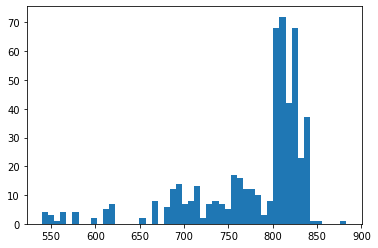

In [133]:
plt.hist(result, bins=50)

,R_ACNML,R_ADSL2r,R_CRTNsyn_cho,R_FBA5,R_GGLUCT,R_HMGLm,R_HMGLx,R_KYNATESYN,R_MDRPD,R_MGACONm,...,R_12DHCHOLt2,R_3DHCDCHOLabc,R_3DHCDCHOLt,R_3DHCDCHOLt2,R_3DHDCAS,R_3DHDCAt,R_3DHLCAt,R_FVSCOAhc,R_MDZGLChr,R_TMACMPhr
{M_prohistyr_c},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
{M_proleuarg_e},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
{M_hs_pre14_g},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
{M_nadp_e},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
{M_5fthf_e},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
{M_rsvlac_c=M_rsvlac_r},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
{M_tlacfvs_c=M_tlacfvs_e=M_tlacfvs_r},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
{M_tmdm1_c=M_tmdm1_r},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
{M_tmdm5_c=M_tmdm5_r},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
dummy_lower_inverse.max().sum()

6825.103949165858

In [140]:
m.rref_operation.max().sum()

9.7162595833864e+75

In [144]:
error_series.index[res_loc]

Index(['R_RNMK', 'R_RE1810M', 'R_HMR_0875', 'R_GLCAASE7ly', 'R_HMR_0876',
       'R_SUCD1m', 'R_CYOOm2i', 'R_HEXA1l', 'R_PPAm', 'R_NACHEX25ly',
       ...
       'R_TMDM5hr', 'R_FTHFDH', 'R_MMCDm', 'R_HMR_3173', 'R_PTVSTM3hc',
       'R_HMR_1754', 'R_XAO2x', 'R_ETHAAL', 'R_HMR_6755', 'R_ST8SIA12'],
      dtype='object', length=550)

In [151]:
dummy_s = m.som_stoichiometry_matrix[result_labels[0]]
dummy_s

,R_S3T1g,R_RNMK,R_S3T2g,R_G5SADrm,R_RE1810M,R_HMR_0875,R_GLCAASE7ly,R_HMR_0876,R_FACOAL1812,R_SUCD1m,...,R_FTHFDH,R_MMCDm,R_AM1ALCSteb,R_HMR_3173,R_PTVSTM3hc,R_HMR_1754,R_XAO2x,R_ETHAAL,R_HMR_6755,R_ST8SIA12
{M_prohistyr_c},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
{M_proleuarg_e},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
{M_hs_pre14_g},1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
{M_nadp_e},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
{M_5fthf_e},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
{M_rsvlac_c=M_rsvlac_r},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
{M_tlacfvs_c=M_tlacfvs_e=M_tlacfvs_r},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
{M_tmdm1_c=M_tmdm1_r},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
{M_tmdm5_c=M_tmdm5_r},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [224]:

import warnings
warnings.filterwarnings('ignore')

In [237]:
# solve reduced stoichimetry matrix
# The following result is from echelon errors
lp_results = []
lp_nit = []
count = 0
for reactions in result_labels:
  count += 1
  if count%50 == 0:
    print("We are at model %d" % count)
  select_mat = m.som_stoichiometry_matrix[reactions]
  lp_mat = select_mat.loc[(select_mat!=0.0).any(axis=1)].T
  nmet = lp_mat.shape[1]
  # number of reactions
  nreac = lp_mat.shape[0]  
  #  
  b = np.zeros(nreac)
  c = np.ones(nmet)
  # Linear programming. c is constraint (here, zero), 
  # b is vector of possible values for molecule vector. 
  lp_res = linprog(c, A_eq=lp_mat, b_eq=b, bounds=(1, None))
  lp_results.append(lp_res.status)
  # number of iterations; for most cases it should be greater than zero
  # as zero means no iteration == trivially infeasible. 
  lp_nit.append(lp_res.nit)

We are at model 50
We are at model 100
We are at model 150
We are at model 200
We are at model 250
We are at model 300
We are at model 350
We are at model 400
We are at model 450
We are at model 500


In [242]:
from collections import Counter
Counter(lp_results)

Counter({2: 454, 1: 34, 0: 32})

In [258]:
type3_num

[808, 831, 779, 728, 805, 792, 728, 803]

In [246]:
# solve reduced stoichimetry matrix
# The following result is from type III errors
type3_num = []
type3_labels = []
for error_reaction in m.type_three_errors:
  error_series = operation_df.T[error_reaction.label]
  res_loc = error_series.to_numpy().nonzero()
  # labels of reactions
  res_reactions = error_series.index[res_loc]
  type3_num.append(len(res_loc[0]))
  type3_labels.append(res_reactions)
# print(type3_num)
# print(type3_labels)
lp_type3_results = []
lp_type3_nit = []
count = 0
for reactions in type3_labels:
  count += 1
  if count%50 == 0:
    print("We are at model %d" % count)
  select_mat = m.som_stoichiometry_matrix[reactions]
  lp_mat = select_mat.loc[(select_mat!=0.0).any(axis=1)].T
  nmet = lp_mat.shape[1]
  # number of reactions
  nreac = lp_mat.shape[0]  
  #  
  b = np.zeros(nreac)
  c = np.ones(nmet)
  # Linear programming. c is constraint (here, zero), 
  # b is vector of possible values for molecule vector. 
  lp_res = linprog(c, A_eq=lp_mat, b_eq=b, bounds=(1, None))
  lp_type3_results.append(lp_res.status)
  # number of iterations; for most cases it should be greater than zero
  # as zero means no iteration == trivially infeasible. 
  lp_type3_nit.append(lp_res.nit)

In [250]:
lp_combined_results = lp_results + lp_type3_results
print(len(lp_combined_results))
print(lp_type3_results)

528
[2, 2, 2, 2, 2, 2, 2, 2]


In [248]:
Counter(lp_combined_results)

Counter({2: 462, 1: 34, 0: 32})

In [204]:
# cound number of non-zero elements for each SOM
nonzero_counts = []
for reac in lp_mat.columns:
  nonzero_counts.append(np.count_nonzero(lp_mat[reac]))
print(nonzero_counts)

[5, 5, 5, 4, 5, 2, 5, 4, 4, 5, 6, 4, 5, 4, 4, 4, 8, 7, 5, 7, 6, 5, 5, 4, 4, 7, 6, 4, 6, 6, 5, 5, 5, 4, 5, 6, 5, 5, 5, 5, 5, 5, 5, 10, 3, 5, 4, 6, 3, 7, 4, 4, 5, 5, 3, 5, 5, 3, 7, 7, 9, 5, 5, 3, 3, 5, 5, 5, 4, 5, 5, 4, 4, 5, 9, 6, 5, 4, 4, 4, 5, 5, 5, 7, 5, 5, 5, 4, 5, 5, 6, 7, 6, 6, 5, 6, 4, 3, 6, 5, 4, 4, 5, 5, 6, 3, 5, 6, 5, 4, 4, 5, 7, 6, 5, 5, 5, 7, 3, 6, 6, 4, 4, 4, 4, 4, 2, 7, 4, 7, 5, 7, 7, 4, 6, 5, 6, 4, 5, 4, 6, 4, 5, 9, 4, 5, 6, 5, 5, 6, 5, 5, 6, 4, 7, 4, 3, 5, 5, 4, 4, 7, 3, 4, 5, 6, 7, 6, 4, 7, 4, 5, 3, 4, 5, 5, 4, 7, 5, 7, 5, 3, 8, 6, 4, 5, 5, 5, 5, 7, 5, 3, 4, 2, 5, 7, 5, 7, 5, 5, 5, 3, 4, 7, 5, 5, 4, 3, 4, 4, 7, 4, 5, 5, 4, 5, 4, 4, 4, 7, 5, 2, 6, 7, 4, 4, 6, 2, 8, 4, 7, 3, 5, 7, 5, 5, 6, 7, 7, 4, 4, 5, 5, 4, 4, 4, 4, 4, 4, 4, 8, 5, 6, 4, 4, 10, 6, 4, 10, 4, 4, 4, 4, 4, 2, 7, 4, 6, 6, 2, 4, 3, 5, 8, 6, 10, 7, 5, 7, 4, 7, 7, 2, 4, 4, 4, 4, 5, 5, 4, 5, 3, 4, 5, 4, 3, 4, 4, 5, 4, 4, 5, 5, 5, 5, 4, 4, 2, 4, 3, 2, 5, 6, 7, 5, 3, 4, 4, 7, 5, 5, 4, 4, 6, 6, 5, 5, 5, 10, 4, 3, 7

In [216]:
# dummy_array = np.array([[-1.0, 1.0, 0.0, 0.0],[0.0, 0.0, 1.0, -1.0]])
dummy_array = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],[0.0, 0.0, 0.0, 1.0, -1.0]])
dummy_array

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -1.]])

In [217]:
select_mat = m.som_stoichiometry_matrix[reactions]
#lp_mat = select_mat.loc[(select_mat!=0.0).any(axis=1)]
lp_mat = dummy_array
nmet = lp_mat.shape[0]
# number of reactions
nreac = lp_mat.shape[1]  
#  
b = np.zeros(nmet)
c = np.ones(nreac)
# Linear programming. c is constraint (here, zero), 
# b is vector of possible values for molecule vector. 
lp_res = linprog(c, A_eq=lp_mat, b_eq=b, bounds=(1, None))
print(lp_res)

     con: array([0., 0.])
     fun: 2.0
 message: 'The problem is (trivially) infeasible because a singleton row in the equality constraints is inconsistent with the bounds.'
     nit: 0
   slack: array([], dtype=float64)
  status: 2
 success: False
       x: array([0., 1., 1., 0., 0.])


In [266]:
m.echelon_errors[:3]

[R_RNMK: {M_rnam_c} -> ,
 R_TYRALAt: {M_tyrala_e} -> ,
 R_TYRALAr: {M_tyrala_c} -> ]